In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from darts import TimeSeries

In [365]:
def find_adi(ts_arr):
    try:
        n_periods = len(ts_arr)
    except:
        n_periods = 1
    
    demand_buckets = np.count_nonzero(ts_arr)
    adi = n_periods/demand_buckets
    
    return adi

def find_cv(ts_arr):
    
    idx_non_zero = ts_arr.nonzero()[0]
    arr_non_zero = ts_arr[idx_non_zero]

    return arr_non_zero.std() / arr_non_zero.mean()

In [366]:
MIN_SOLD = 50

df = (
    pd.read_feather('../data/interim/order_dataset_to_forecastability')
    .assign(sale_date = lambda x: pd.to_datetime(x.sale_date))
    .drop('seller_id', axis=1)
)

In [367]:
most_sold_skus = df.sku_id.value_counts()[df.sku_id.value_counts() > MIN_SOLD].index.tolist()

In [368]:
df_most_sold = df[df.sku_id.isin(most_sold_skus)].copy()

In [369]:
df_most_sold.drop_duplicates(subset=['sale_date','sku_id'], keep=False, inplace=True)

In [370]:
ts = TimeSeries.from_group_dataframe(df_most_sold, 
                                 group_cols='sku_id', 
                                 time_col='sale_date',
                                 value_cols='qty',
                                 fill_missing_dates=True,
                                 freq='D', 
                                 fillna_value=0,
                                 static_cols=None)

In [371]:
demand_class = {}

for series in ts:
    arr = series.values().squeeze()
    adi, cv2 = find_adi(arr), find_cv(arr)**2
    demand_class[series.static_covariates['sku_id']['qty']] = [adi, cv2]

In [372]:
arr = np.array(list(demand_class.values()))

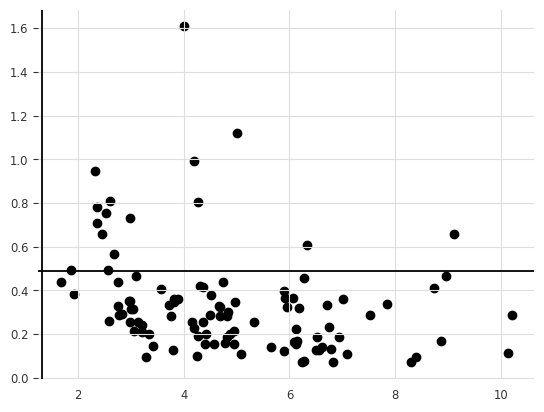

In [373]:
plt.scatter(arr[:,0], arr[:,1])
plt.axvline(1.32)
plt.axhline(0.49)

In [379]:
demand_class['0aabfb375647d9738ad0f7b4ea3653b1']

[3.72, 0.33293093908757093]

In [377]:
ts[2].static_covariates_values()

array([['0aabfb375647d9738ad0f7b4ea3653b1']], dtype=object)

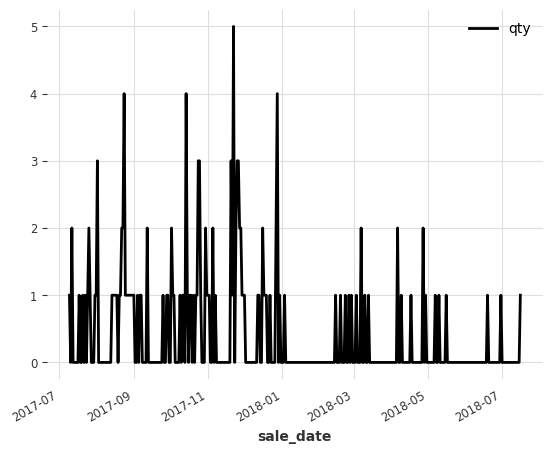

In [374]:
ts[2].plot()

<TimeSeries (DataArray) (sale_date: 433, component: 1, sample: 1)>
array([[[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-06-14 2017-06-15 ... 2018-08-20
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                            sku_id\n...
    hierarchy:          None

In [292]:
train, test = ts[0].split_before(len(ts[0])-36)

In [294]:
model = NaiveSeasonal(K=12)
model.fit(train)

NaiveSeasonal(K=12)

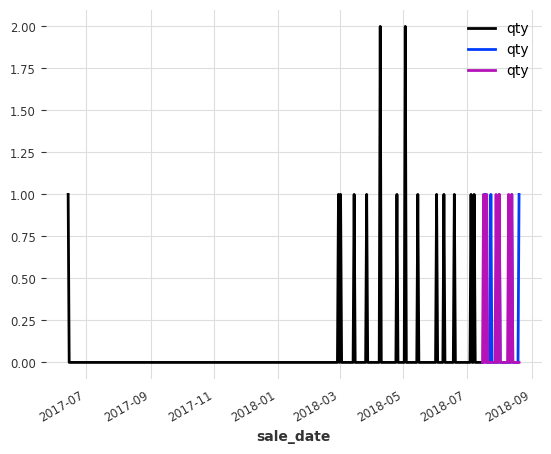

In [298]:
train.plot()
test.plot()
model.predict(36).plot()

In [301]:
from darts.metrics import rmse, mape

In [303]:
rmse(test, model.predict(36))

0.4714045207910317

In [305]:
from darts.models import RandomForest

In [323]:
model = LightGBMModel(lags=[-1,-3,-5,-7,-12], 
                      use_static_covariates=False,
                      output_chunk_length=36)

In [324]:
model.fit(train)

LightGBMModel(lags=[-1, -3, -5, -7, -12], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=36, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=False, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

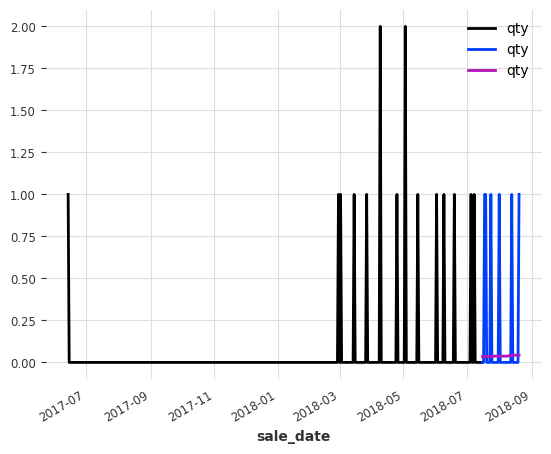

In [326]:
train.plot()
test.plot()
model.predict(36).plot()

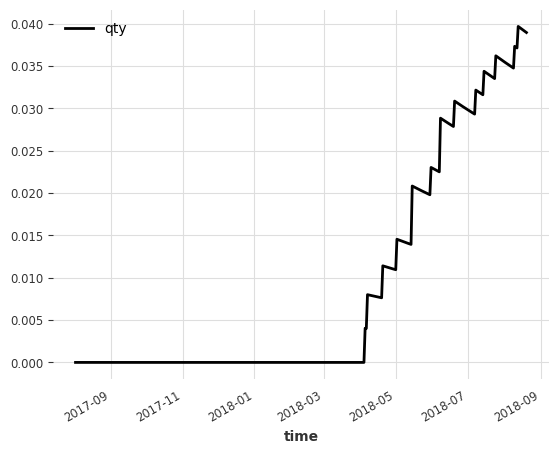

In [328]:
model.historical_forecasts(ts[0]).plot()

In [304]:
model = LightGBMModel(lags=[-1,-3,-5])
model.fit(ts[0])

ValueError: could not convert string to float: '008cff0e5792219fae03e570f980b330'

In [164]:
dc_most_sold = {}
k = 25

for seller in tqdm(df.seller_id.unique()):
    most_sold_skus = df[df.seller_id == seller].groupby('sku_id').sale_date.count().nlargest(3)
    if most_sold_skus.mean() >= k:
        dc_most_sold[seller] = most_sold_skus.index.values.tolist()

100%|██████████████████████████████████████████████████████████████████████| 2970/2970 [00:07<00:00, 381.71it/s]


In [230]:
demand_class = {}

for seller in dc_most_sold.keys():
    
    if seller not in demand_class.keys():  
        demand_class[seller] = []
    
    most_sold_df = df[(df.seller_id == seller)&
                      (df.sku_id.isin(dc_most_sold[seller]))]
    
    ts = TimeSeries.from_group_dataframe(most_sold_df, 
                                     group_cols='sku_id', 
                                     time_col='sale_date',
                                     value_cols='qty',
                                     fill_missing_dates=True,
                                     freq='D', 
                                     fillna_value=0,
                                     static_cols=None)
    
    for series in ts:
        arr = series.values().squeeze()
        adi, cv2 = find_adi(arr), find_cv(arr)**2
        demand_class[seller].append((series.static_covariates['sku_id']['qty'], adi, cv2))

/tmp/ipykernel_6927/2675814074.py:14: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  idx_non_zero = ts_arr.nonzero()[0]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [231]:
demand_class

{'620c87c171fb2a6dd6e8bb4dec959fc6': [('24c66f106f642621e524291a895c9032',
   7.021739130434782,
   0.2302958579881656),
  ('473795a355d29305c3ea6b156833adf5', 10.2, 0.28538249383074465),
  ('f40876e0ef3cd5f9132b1f16b04b1346',
   6.466666666666667,
   0.20495867768595039)],
 'cca3071e3e9bb7d12640c9fbe2301306': [('07c055536ebf10dfbb6c6db6dbfc36e5',
   12.076923076923077,
   0.08204518430439951),
  ('386486367c1f9d4f587a8864ccb6902b', 10.6, 0.2037037037037037),
  ('c857b96593773e940454e76efa8eabb3',
   6.222222222222222,
   0.24314702741189037)],
 '391fc6631aebcf3004804e51b40bcf1e': [('06edb72f1e0c64b14c5b79353f7abea3',
   4.427184466019417,
   0.19816326530612247),
  ('cfb763496d9fc48751a27db4fd02aa2d',
   20.238095238095237,
   0.09374999999999999),
  ('f6fa93875f4a7dac03e0a22143f4d815',
   21.61904761904762,
   0.17599999999999996)],
 '85d9eb9ddc5d00ca9336a2219c97bb13': [('18b0e642cbae7251e60a64aa07dd9eb9',
   7.846153846153846,
   0.33683617939575916),
  ('a35a9f46dcee0a67c8c7ad8493e

In [165]:
x = df[(df.seller_id == '620c87c171fb2a6dd6e8bb4dec959fc6') & 
       (df.sku_id.isin(dc_most_sold['620c87c171fb2a6dd6e8bb4dec959fc6']))]

In [166]:
x

,sale_date,seller_id,sku_id,qty
60,2016-10-06,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,3
245,2016-10-11,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,1
586,2017-01-24,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,1
763,2017-01-27,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,1
881,2017-01-30,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,1
...,...,...,...,...
81376,2018-07-06,620c87c171fb2a6dd6e8bb4dec959fc6,24c66f106f642621e524291a895c9032,1
84435,2018-07-24,620c87c171fb2a6dd6e8bb4dec959fc6,24c66f106f642621e524291a895c9032,1
84734,2018-07-25,620c87c171fb2a6dd6e8bb4dec959fc6,24c66f106f642621e524291a895c9032,1
86981,2018-08-03,620c87c171fb2a6dd6e8bb4dec959fc6,24c66f106f642621e524291a895c9032,3


In [217]:
ts = TimeSeries.from_group_dataframe(x, 
                                     group_cols='sku_id', 
                                     time_col='sale_date',
                                     value_cols='qty',
                                     fill_missing_dates=True,
                                     freq='D', 
                                     fillna_value=0,
                                     static_cols=None)

In [224]:
ts[0][]

Index(['qty'], dtype='object', name='component')

In [226]:
for arr in ts:
    print((arr.static_covariates['sku_id']['qty'],
         find_adi(arr.values().squeeze()),
         find_cv(arr.values().squeeze())**2))

('24c66f106f642621e524291a895c9032', 7.021739130434782, 0.2302958579881656)
('473795a355d29305c3ea6b156833adf5', 10.2, 0.28538249383074465)
('f40876e0ef3cd5f9132b1f16b04b1346', 6.466666666666667, 0.20495867768595039)


In [ ]:
broken_skus = {}

for arr in ts[:100]:
    try:
        (arr.static_covariates['sku_id']['qty'],
         find_adi(arr.values().squeeze()),
         find_cv(arr.values().squeeze())**2)
    except:
        broken_skus[arr.static_covariates['sku_id']] = len(arr)

In [218]:
find_adi(ts[0].values().squeeze())

7.021739130434782

In [222]:
find_cv(ts[0].values().squeeze())**2

0.2302958579881656

In [185]:
ts[0].head(

<TimeSeries (DataArray) (sale_date: 5, component: 1, sample: 1)>
array([[[1.]],

       [[0.]],

       [[2.]],

       [[1.]],

       [[0.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-09-18 2017-09-19 ... 2017-09-22
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                            sku_id\n...
    hierarchy:          None

In [158]:
ts[0].static_covariates_values()

array([['24c66f106f642621e524291a895c9032']], dtype=object)

In [199]:
from darts.models import LightGBMModel, NaiveSeasonal, CatBoostModel, ExponentialSmoothing

In [211]:
train, test = ts[0].split_before(len(ts[0])-36)

In [212]:
model = ExponentialSmoothing()

In [213]:
model.fit(train)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0)

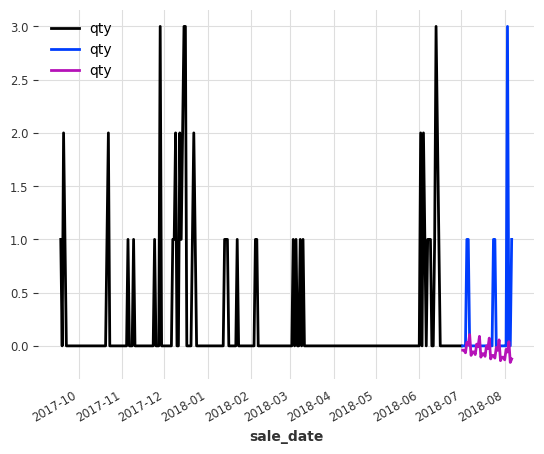

In [216]:
train.plot()
test.plot()
model.predict(36).plot()

<TimeSeries (DataArray) (sale_date: 36, component: 1, sample: 1)>
array([[[-0.04043886]],

       [[-0.04043859]],

       [[-0.06482661]],

       [[ 0.03273664]],

       [[ 0.00834453]],

       [[ 0.10590745]],

       [[-0.08921511]],

       [[-0.05696074]],

       [[-0.05696046]],

       [[-0.08134849]],

...

       [[ 0.05634182]],

       [[-0.13878073]],

       [[-0.10652637]],

       [[-0.10652609]],

       [[-0.13091411]],

       [[-0.03335086]],

       [[-0.05774297]],

       [[ 0.03981994]],

       [[-0.15530261]],

       [[-0.12304824]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2018-07-02 2018-07-03 ... 2018-08-06
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                            sku_id\n...
    hierarchy:          None

In [138]:
ts[0]

<TimeSeries (DataArray) (sale_date: 323, component: 1, sample: 1)>
array([[[1.]],

       [[0.]],

       [[2.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[3.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-09-18 2017-09-19 ... 2018-08-06
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                            sku_id\n...
    hierarchy:          None

In [129]:
model.fit(ts[0])

ValueError: could not convert string to float: '24c66f106f642621e524291a895c9032'

In [72]:
dc_most_sold = {}
k = 25

for seller in tqdm(df.seller_id.unique()):
    most_sold_skus = df[df.seller_id == seller].groupby('sku_id').sale_date.count().nlargest(3)
    if most_sold_skus.mean() >= k:
        dc_most_sold[seller] = most_sold_skus.index.values.tolist()

100%|██████████████████████████████████████████████████████████████████████| 2970/2970 [00:07<00:00, 382.50it/s]


In [83]:
skus_ls = []

for seller in dc_most_sold.items():
    for sku in seller[1]:
        skus_ls.append(sku)

In [87]:
df_most_sold = df[
    (df.seller_id.isin(dc_most_sold.keys()))&
    (df.sku_id.isin(skus_ls))
].reset_index(drop=True)

In [89]:
%%time

ts = TimeSeries.from_group_dataframe(df_most_sold, 
                                     group_cols=['seller_id','sku_id'], 
                                     time_col='sale_date', fill_missing_dates=True,
                                     freq='D', fillna_value=0)

CPU times: user 517 ms, sys: 7.98 ms, total: 525 ms
Wall time: 526 ms


In [92]:
broken_skus = {}

for arr in ts[:100]:
    try:
        (arr.static_covariates['sku_id']['qty'],
         find_adi(arr.values().squeeze()),
         find_cv(arr.values().squeeze())**2)
    except:
        broken_skus[arr.static_covariates['sku_id']] = len(arr)

/tmp/ipykernel_6927/2675814074.py:14: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  idx_non_zero = ts_arr.nonzero()[0]


TypeError: unhashable type: 'Series'

In [27]:
for i, row in df.iterrows():
    print(row)

sale_date                 2016-09-15 00:00:00
seller_id    ecccfa2bb93b34a3bf033cc5d1dcdc69
sku_id       5a6b04657a4c5ee34285d1e4619a96b4
qty                                         3
Name: 0, dtype: object
sale_date                 2016-10-04 00:00:00
seller_id    4b1eaadf791bdbbad8c4a35b65236d52
sku_id       33430c5c1027d812b5c62f778e5ee7f7
qty                                         1
Name: 1, dtype: object
sale_date                 2016-10-04 00:00:00
seller_id    5b179e9e8cc7ab6fd113a46ca584da81
sku_id       29bedbfbe73ea473396306b4f0c010ec
qty                                         1
Name: 2, dtype: object
sale_date                 2016-10-04 00:00:00
seller_id    620c87c171fb2a6dd6e8bb4dec959fc6
sku_id       eba7488e1c67729f045ab43fac426f2e
qty                                         1
Name: 3, dtype: object
sale_date                 2016-10-04 00:00:00
seller_id    624f4ece8da4aafb77699233d480f8ef
sku_id       817e1c2d22418c36386406ccacfa53e8
qty                               

sale_date                 2017-02-17 00:00:00
seller_id    ff063b022a9a0aab91bad2c9088760b7
sku_id       b44e238dee5686eb00c9130a613519b3
qty                                         1
Name: 2090, dtype: object
sale_date                 2017-02-18 00:00:00
seller_id    066a6914e1ebf3ea95a216c73a986b91
sku_id       1b1c78225aa5601414a8c09020ee1803
qty                                         1
Name: 2091, dtype: object
sale_date                 2017-02-18 00:00:00
seller_id    0db783cfcd3b73998abc6e10e59a102f
sku_id       8c5876b1c7768217964f353bc7e64393
qty                                         1
Name: 2092, dtype: object
sale_date                 2017-02-18 00:00:00
seller_id    1554a68530182680ad5c8b042c3ab563
sku_id       f422d0d9f8b5f7c27289382b14b61248
qty                                         2
Name: 2093, dtype: object
sale_date                 2017-02-18 00:00:00
seller_id    1b4c3a6f53068f0b6944d2d005c9fc89
sku_id       8163c8c2e8dc7cc8c93d1b30a2e7428b
qty                   

sale_date                 2017-03-21 00:00:00
seller_id    0c8380b62e38e8a1e6adbeba7eb9688c
sku_id       29353bc591cb0f1a7cfa75382a0c6170
qty                                         1
Name: 4214, dtype: object
sale_date                 2017-03-21 00:00:00
seller_id    1b4c3a6f53068f0b6944d2d005c9fc89
sku_id       e9a69340883a438c3f91739d14d3a56d
qty                                         1
Name: 4215, dtype: object
sale_date                 2017-03-21 00:00:00
seller_id    1da366cade6d8276e7d8beea7af5d4bf
sku_id       a695ab8413ea83619cde9b18292d6aa1
qty                                         1
Name: 4216, dtype: object
sale_date                 2017-03-21 00:00:00
seller_id    2138ccb85b11a4ec1e37afbd1c8eda1f
sku_id       a00a22560435cc439faf6163eabc1ef8
qty                                         1
Name: 4217, dtype: object
sale_date                 2017-03-21 00:00:00
seller_id    2138ccb85b11a4ec1e37afbd1c8eda1f
sku_id       d952c09021388fd5b1e5f914f559fb10
qty                   

sale_date                 2017-04-18 00:00:00
seller_id    cc419e0650a3c5ba77189a1882b7556a
sku_id       154e7e31ebfa092203795c972e5804a6
qty                                         1
Name: 6303, dtype: object
sale_date                 2017-04-18 00:00:00
seller_id    cc419e0650a3c5ba77189a1882b7556a
sku_id       7c1bd920dbdf22470b68bde975dd3ccf
qty                                         1
Name: 6304, dtype: object
sale_date                 2017-04-18 00:00:00
seller_id    cca3071e3e9bb7d12640c9fbe2301306
sku_id       386486367c1f9d4f587a8864ccb6902b
qty                                         2
Name: 6305, dtype: object
sale_date                 2017-04-18 00:00:00
seller_id    cca3071e3e9bb7d12640c9fbe2301306
sku_id       741158fada4f10d804c017c381d6925e
qty                                         1
Name: 6306, dtype: object
sale_date                 2017-04-18 00:00:00
seller_id    cca3071e3e9bb7d12640c9fbe2301306
sku_id       94bf3dc3d35d6e2dc1be8edffe180c59
qty                   

sale_date                 2017-05-09 00:00:00
seller_id    e21a1e8be4715b0fcfd5385643bc49c4
sku_id       50f5f13adab483598dfb6a40afaf70b6
qty                                         1
Name: 8300, dtype: object
sale_date                 2017-05-09 00:00:00
seller_id    e26901d5ab434ce92fd9b5c256820a4e
sku_id       0bb7cb61f1957f79dac582ab66ccdc1f
qty                                         2
Name: 8301, dtype: object
sale_date                 2017-05-09 00:00:00
seller_id    e26901d5ab434ce92fd9b5c256820a4e
sku_id       7b453aa3584d61c1268d77ba6fd5956b
qty                                         1
Name: 8302, dtype: object
sale_date                 2017-05-09 00:00:00
seller_id    e26901d5ab434ce92fd9b5c256820a4e
sku_id       a298a105818dce6878b787e4af6cff7d
qty                                         1
Name: 8303, dtype: object
sale_date                 2017-05-09 00:00:00
seller_id    ebd2d60905fb58271facef5596b620d3
sku_id       d950ce1f38b6772552be4523baf94c7a
qty                   

sale_date                 2017-05-27 00:00:00
seller_id    6cd68b3ed6d59aaa9fece558ad360c0a
sku_id       f75eb66dc82bccecabd706bd441cfd3a
qty                                         1
Name: 10386, dtype: object
sale_date                 2017-05-27 00:00:00
seller_id    7a241947449cc45dbfda4f9d0798d9d0
sku_id       ebb7ccdb2a728a4188759bfa3cbd1fc0
qty                                         1
Name: 10387, dtype: object
sale_date                 2017-05-27 00:00:00
seller_id    7a67c85e85bb2ce8582c35f2203ad736
sku_id       c6dd917a0be2a704582055949915ab32
qty                                         1
Name: 10388, dtype: object
sale_date                 2017-05-27 00:00:00
seller_id    7e93a43ef30c4f03f38b393420bc753a
sku_id       4e5e41fb7d296a6f776c63fee5cb9fac
qty                                         1
Name: 10389, dtype: object
sale_date                 2017-05-27 00:00:00
seller_id    7e93a43ef30c4f03f38b393420bc753a
sku_id       8effae0c3be3eab7870860070ca5e51a
qty               

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
most_sold = (
    df
    .groupby(['seller_id','sku_id'])
    .qty
    .count()
    .reset_index()
    .query("qty > @k")
    .sku_id
    .values
)

In [25]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].sku_id.value_counts()

d017a2151d543a9885604dc62a3d9dcc    110
a92930c327948861c015c919a0bcb4a8     91
2136c70bbe723d338fab53da3c03e6dc     73
c3ba4e8d3cb30049213b682e751e9d00     48
dc52f0f5d3ec37a93eaf956cde4e5d2c     35
                                   ... 
457c5f8a59156ce6315753d8d788a16a      1
924b2122bcd5d6eb53d37a167d3b1d47      1
772453e71330bbe06de41e9baf8495ac      1
15557c53492889a2b63e65df34a738ab      1
8bd822c04ee6a8292a7b0debc3dbd74a      1
Name: sku_id, Length: 254, dtype: int64

In [22]:
df.groupby('seller_id').sku_id.count().sort_values(ascending=False)

seller_id
6560211a19b47992c3666cc44a7e94c0    1787
4a3ca9315b744ce9f8e9374361493884    1600
da8622b14eb17ae2831f4ac5b9dab84a    1358
cc419e0650a3c5ba77189a1882b7556a    1316
ea8482cd71df3c1969d7b9473ff13abc    1064
                                    ... 
d263fa444c1504a75cbca5cc465f592a       1
d297f1055de2956aedfd3b04113dce3e       1
2a73cba571d90c694b7caca072ccf6ce       1
88cd3681e0a2ba85e190f7d817629c4c       1
2cb98e27ce1c18abdb42209b34c382a7       1
Name: sku_id, Length: 2970, dtype: int64

In [13]:
df_most_sold = df[df.sku_id.isin(most_sold)]

In [14]:
%%time

ts = TimeSeries.from_group_dataframe(df_most_sold, 
                                     group_cols=['seller_id','sku_id'], 
                                     time_col='sale_date', fill_missing_dates=True,
                                     freq='D', fillna_value=0)

CPU times: user 1.74 s, sys: 19.4 ms, total: 1.76 s
Wall time: 1.77 s


In [17]:
for arr in ts[:100]:
    print((arr.static_covariates['sku_id']['qty'], 
           find_adi(arr.values().squeeze()), 
           find_cv(arr.values().squeeze())**2))

('08574b074924071f4e201e151b152b4e', 4.666666666666667, 0.32793388429752074)
('0da9ffd92214425d880de3f94e74ce39', 24.1875, 0.051903114186851215)
('98a8c2fa16d7239c606640f5555768e4', 14.08, 0.09988109393579071)
('e251ebd2858be1aa7d9b2087a6992580', 6.90625, 0.40516070620190137)
('158102fe543dbaeb84d87811bfe06d0d', 11.75, 0.0)
('10717ff440b2320081989126e858b220', 8.9375, 0.3424036281179139)
('363218ba55c610b750224f90bdd34be1', 17.3, 0.07438016528925619)
('726b4e18f00255e2e63491bcba3f60b8', 6.3, 0.07438016528925619)
('0d85c435fd60b277ffb9e9b0f88f927a', 1.0, 0.1111111111111111)
('36f60d45225e60c7da4558b070ce4b60', 2.857142857142857, 0.26388888888888895)
('3f14d740544f37ece8a9e7bc8349797e', 3.25, 0.5510204081632654)
('656e0eca68dcecf6a31b8ececfabe3e8', 5.636363636363637, 0.39039999999999997)
('dbb67791e405873b259e4656bf971246', 1.7777777777777777, 0.5000000000000001)
('e53e557d5a159f5aa2c5e995dfdf244b', 8.714285714285714, 0.1234567901234568)
('ca38c039b717207dec906f4fa9a21db7', 6.5, 0.0)
('d

TypeError: len() of unsized object

In [90]:
t = ts[4].values().squeeze()
t.

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [72]:
find_adi(arr),find_cv(arr)

(4.666666666666667, 0.57265511810995)

In [59]:
arr = ts[1].values().squeeze()

arr[arr.nonzero()[0]].std() / arr[arr.nonzero()[0]].mean()

0.57265511810995

In [27]:
from darts.metrics import coefficient_of_variation

In [114]:
ts[1].static_covariates

static_covariates,seller_id,sku_id
component,,
qty,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e


In [90]:
ts[1]

<TimeSeries (DataArray) (sale_date: 364, component: 1, sample: 1)>
array([[[2.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-03-15 2017-03-16 ... 2018-03-13
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                         seller_id  ...
    hierarchy:          None

In [91]:
ts[1].static_covariates_values()

array([['001cca7ae9ae17fb1caed9dfb1094831',
        '08574b074924071f4e201e151b152b4e']], dtype=object)

In [92]:
df[(df.seller_id == ts[1].static_covariates_values()[0][0])&(df.sku_id == ts[1].static_covariates_values()[0][1])]

,sale_date,seller_id,sku_id,qty
3724,2017-03-15,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,2
4537,2017-03-25,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
4671,2017-03-27,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,2
5036,2017-03-31,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
5153,2017-04-02,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
...,...,...,...,...
45077,2018-01-15,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
47886,2018-01-27,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
50401,2018-02-08,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
52763,2018-02-20,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1


In [93]:
len(ts[1])-14

350

In [94]:
from darts.models import NaiveSeasonal

train, test = (
    ts[1]
    .add_holidays('BRA')
    .add_datetime_attribute('week', cyclic=True)
    .add_datetime_attribute('month', cyclic=True)
).split_before(len(ts[1])-30)


naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(30)

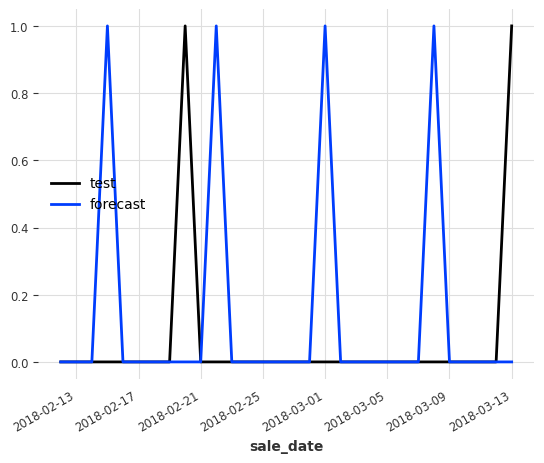

In [95]:
test['qty'].plot(label='test')
naive_forecast['qty'].plot(label='forecast')

In [96]:
from darts.metrics import mape, rmse, mae

In [97]:
rmse(test['qty'], naive_forecast['qty'])
mae(test['qty'], naive_forecast['qty'])

0.2

In [115]:
from darts.models import CatBoostModel

train, test = (
    ts[1]
#     .add_holidays('BRA')
#     .add_datetime_attribute('week', cyclic=True)
#     .add_datetime_attribute('month', cyclic=True)
).split_before(len(ts[1])-30)


model = CatBoostModel(lags=7)
model.fit(train)
model_forecast = model.predict(30)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=7]="001cca7ae9ae17fb1caed9dfb1094831": Cannot convert 'b'001cca7ae9ae17fb1caed9dfb1094831'' to float

In [113]:
ts[1]

<TimeSeries (DataArray) (sale_date: 364, component: 1, sample: 1)>
array([[[2.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-03-15 2017-03-16 ... 2018-03-13
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                         seller_id  ...
    hierarchy:          None

In [ ]:
test['qty'].plot(label='test')
naive_forecast['qty'].plot(label='forecast')

In [32]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].sale_date.min()

Timestamp('2017-02-17 00:00:00')

In [33]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].sale_date.max()

Timestamp('2018-08-29 00:00:00')

In [26]:
def 

df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0']

,sale_date,seller_id,sku_id,qty
2064,2017-02-17,6560211a19b47992c3666cc44a7e94c0,ef79ec374ba852bbced7662285946619,1
2400,2017-02-24,6560211a19b47992c3666cc44a7e94c0,380b4664ba5bb18cc9db78ee6bac3558,1
2401,2017-02-24,6560211a19b47992c3666cc44a7e94c0,aa0816cf69c9faa95e573541be5c0c32,1
2402,2017-02-24,6560211a19b47992c3666cc44a7e94c0,c708ba7c6269161f89ce0683cdd7c432,1
2531,2017-02-27,6560211a19b47992c3666cc44a7e94c0,5d7c23067ed3fc8c6e699b9373d5890b,1
...,...,...,...,...
92464,2018-08-27,6560211a19b47992c3666cc44a7e94c0,c708ba7c6269161f89ce0683cdd7c432,1
92525,2018-08-28,6560211a19b47992c3666cc44a7e94c0,5403528d987ad26e8d7cb25940411987,1
92526,2018-08-28,6560211a19b47992c3666cc44a7e94c0,c3ba4e8d3cb30049213b682e751e9d00,2
92527,2018-08-28,6560211a19b47992c3666cc44a7e94c0,e06f99e79036d681effa3de75989bf22,1


In [25]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].pivot_table(index='sku_id',columns='sale_date', values='qty')

sale_date,2017-02-17,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-03,2017-03-04,2017-03-06,2017-03-07,2017-03-08,...,2018-08-18,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-25,2018-08-27,2018-08-28,2018-08-29
sku_id,,,,,,,,,,,,,,,,,,,,,
0067f97995b0c3a86739734dc87ee6b6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01365901d8f2247976a7e5d4c98c52c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02475368dfb38934fe55f574024fe1d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04867a0efbf0779b221235559860b9b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04af9f3af5c6afc4eece909c25330934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f683f3a5d367251ac1a86404f15615b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f883c296edea388761ae3de2bc4870f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f93abb853eee25cbbce73bbc1c10667d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
